**Import Required Libraries**

In [ ]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# NLP Libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

# Sklearn Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# TensorFlow & Keras Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load SpaCy model
nlp = en_core_web_sm.load()

# Ignore warnings
warnings.filterwarnings('ignore')

# Set pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load & Process Dataset**

In [ ]:
# Load JSON dataset
with open('/content/drive/MyDrive/IT_Ticket/complaints-2021-05-14_08_16_.json') as j:
    data = json.load(j)

df = pd.json_normalize(data)

# Retain required columns
df = df[['_source.complaint_what_happened', '_source.product', '_source.sub_product']]
df = df.rename(columns={
    '_source.complaint_what_happened': 'complaint_text',
    '_source.product': 'category',
    '_source.sub_product': 'sub_category'
})

# Merge category & sub-category
df['category'] = df['category'] + '+' + df['sub_category']
df.drop(['sub_category'], axis=1, inplace=True)

# Drop empty complaints
df.replace('', np.nan, inplace=True)
df.dropna(subset=['complaint_text'], inplace=True)


In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 10.5 MB/s eta 0:00:00


**Text Preprocessing**

In [ ]:
# Text cleaning function
import contractions
def clean_text(text):
    text = contractions.fix(text)  # Expand contractions like "can't" -> "cannot"
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\S*\d\S*\s*', '', text)  # Remove words containing numbers
    return text.strip()

# Apply cleaning
df['complaint_text'] = df['complaint_text'].apply(clean_text)

# Lemmatization
stop_words = set(stopwords.words('english'))
def lemmatizer(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.text not in stop_words])
df['lemma'] = df['complaint_text'].apply(lemmatizer)

**POS Tagging & Additional Cleaning**

In [ ]:
def extract_pos_tags(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if token.tag_ == 'NN'])

df['complaint_POS_removed'] = df['lemma'].apply(extract_pos_tags)

# Ensure "Complaint_clean" exists before applying .replace()
df['Complaint_clean'] = df['lemma'].str.replace('xxxx', '')


**Exploratory data analysis (EDA)**

(array([9.262e+03, 6.362e+03, 2.699e+03, 1.279e+03, 7.550e+02, 2.810e+02,
        1.370e+02, 8.000e+01, 5.700e+01, 3.600e+01, 3.600e+01, 1.400e+01,
        1.000e+01, 1.400e+01, 8.000e+00, 5.000e+00, 8.000e+00, 2.000e+00,
        3.000e+00, 4.000e+00, 3.000e+00, 5.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([    0.  ,   250.56,   501.12,   751.68,  1002.24,  1252.8 ,
         1503.36,  1753.92,  2004.48,  2255.04,  2505.6 ,  2756.16,
         3006.72,  3257.28,  3507.84,  3758.4 ,  4008.96,  4259.52,
         4510.08,  4760.64,  5011.2 ,  5261.76,  5512.32,  5762.88,
         6013.44,  6264.  ,  6514.56,  6765.12,  7015.68,  7266.24,
         7516.8 ,  7767.36,  8017.92

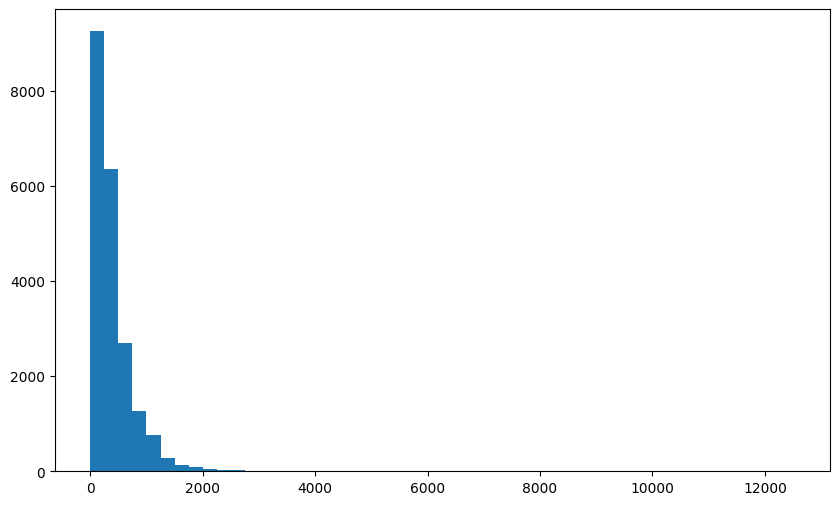

In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)

**word cloud image**

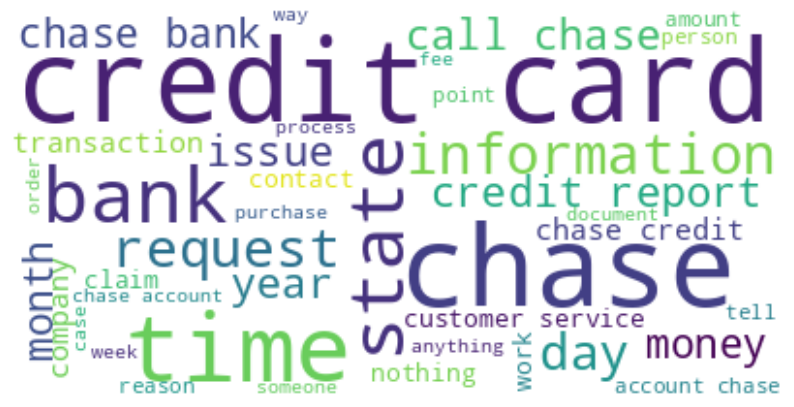

In [ ]:
## Import necessary libraries for generating a word cloud
from wordcloud import WordCloud
from nltk.corpus import stopwords

# Create a set of English stopwords to exclude common words from the visualization
stop_words = set(stopwords.words('english'))  # convert to Python set

wordcloud = WordCloud(stopwords=stop_words, max_words=40, background_color='white').generate(' '.join(df['complaint_POS_removed']))

# Display the generated word cloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
#Removing -PRON- from the text corpus
df['Complaint_clean'] = df['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean = df.drop(['complaint_POS_removed'],axis = 1)

**Finding the Top Unigrams, Bigrams and Trigrams**

In [ ]:
# Write your code here to find the top 30 unigram,bigram,trigram frequency
# among the complaints in the cleaned datafram(df_clean).

def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

In [ ]:
top_30_unigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=3, top=30)

In [ ]:
#Print the top 10 words in the unigram frequency
print('Top 10 unigrams:\n')
top_30_unigrams[:10]

Top 10 unigrams:



[('chase', np.int64(59801)),
 ('account', np.int64(43103)),
 ('credit', np.int64(33528)),
 ('card', np.int64(29982)),
 ('payment', np.int64(21068)),
 ('charge', np.int64(15631)),
 ('time', np.int64(15618)),
 ('bank', np.int64(14558)),
 ('day', np.int64(12321)),
 ('money', np.int64(11719))]

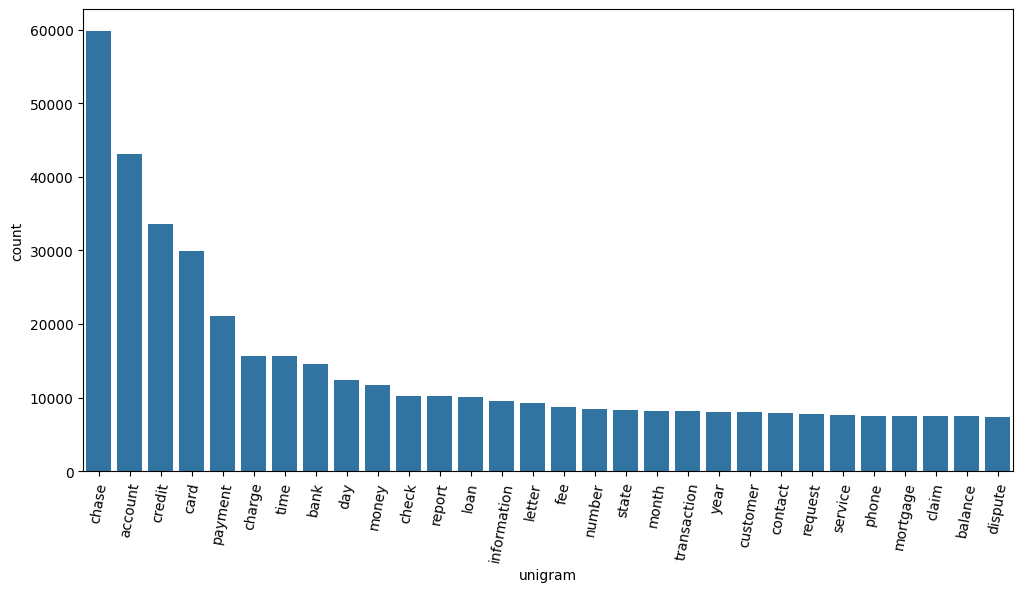

In [ ]:
#Plot graph for the top 30 words in the unigram frequency
df1 = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df1['unigram'], y=df1['count'])
plt.xticks(rotation = 80)
plt.show()

In [ ]:
#Print the top 10 words in the bigram frequency
print('Top 10 bigrams:\n')
top_30_bigrams[:10]

Top 10 bigrams:



[('credit card', np.int64(12735)),
 ('credit report', np.int64(3881)),
 ('chase bank', np.int64(3201)),
 ('chase credit', np.int64(3148)),
 ('account chase', np.int64(3056)),
 ('customer service', np.int64(2965)),
 ('chase account', np.int64(2466)),
 ('account account', np.int64(2046)),
 ('contact chase', np.int64(2037)),
 ('debit card', np.int64(1937))]

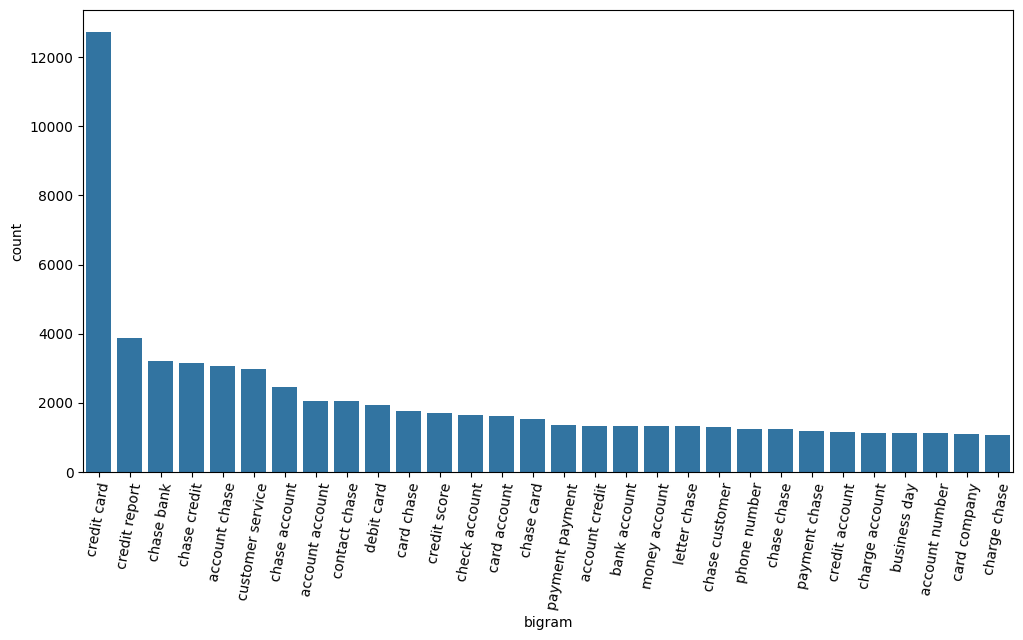

In [ ]:
#Plot graph for the top 30 words in the bigram frequency
df2 = pd.DataFrame(top_30_bigrams, columns = ['bigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df2['bigram'], y=df2['count'])
plt.xticks(rotation = 80)
plt.show()

In [ ]:
#Print the top 10 words in the trigram frequency
print('Top 10 trigrams:\n')
top_30_trigrams[:10]

Top 10 trigrams:



[('chase credit card', np.int64(2216)),
 ('credit card account', np.int64(1069)),
 ('credit card company', np.int64(981)),
 ('credit card chase', np.int64(874)),
 ('chase customer service', np.int64(626)),
 ('inquiry credit report', np.int64(501)),
 ('charge credit card', np.int64(460)),
 ('credit card credit', np.int64(450)),
 ('credit reporting agency', np.int64(376)),
 ('account credit card', np.int64(370))]

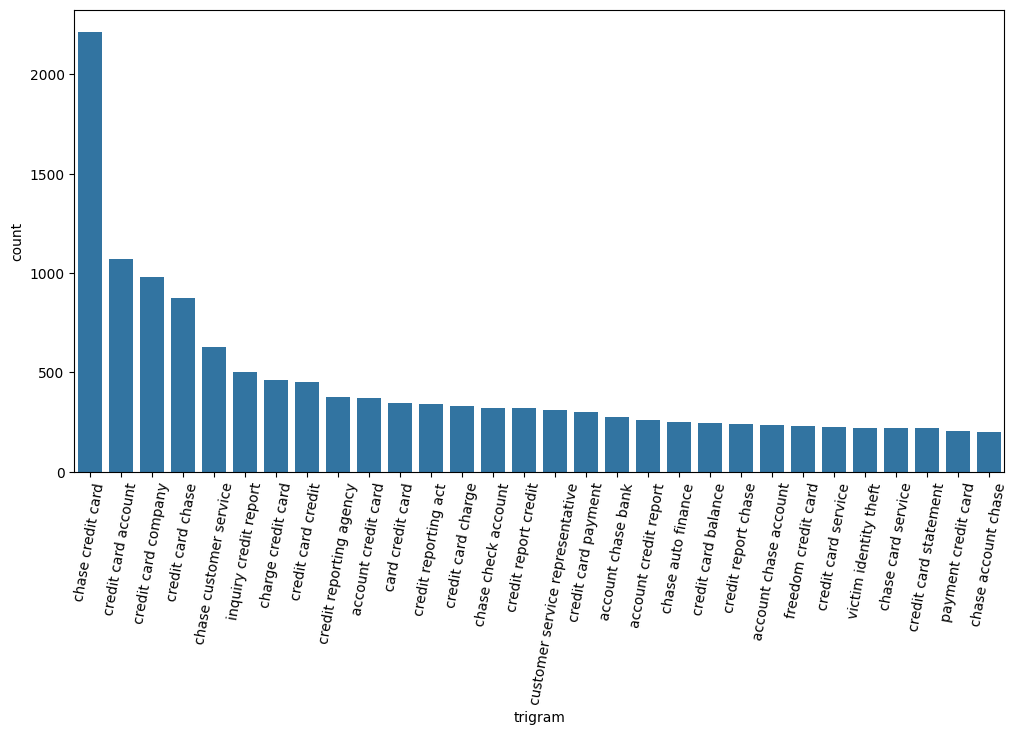

In [ ]:
#Plot graph for the top 30 words in the trigram frequency
df3 = pd.DataFrame(top_30_trigrams, columns = ['trigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df3['trigram'], y=df3['count'])
plt.xticks(rotation = 80)
plt.show()

**The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis**

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean.head()

,complaint_text,category,lemma,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Debt collection+Credit card debt,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning name chase debt verification statement validate debt mail month attempt debt information consumer chase account advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Credit card or prepaid card+General-purpose credit card or charge card,upgrade xxxx xxxx card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent mislead,agent upgrade anniversary date agent information order account change anniversary date consent agent mislead
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,"Credit reporting, credit repair services, or other personal consumer reports+Other personal consumer report",chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,card report application identity consent service extend credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,"Credit reporting, credit repair services, or other personal consumer reports+Credit reporting",try book xxxx xxxx ticket come across offer apply towards ticket apply reward card put information offer within less minute notify via screen decision could make 

**TF-IDF Vectorization & Topic Modeling**

In [ ]:
from sklearn.decomposition import NMF
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(min_df=5, max_df=0.9, stop_words='english', ngram_range=(1,2))

# Create Document-Term Matrix
dtm = tfidf.fit_transform(df['Complaint_clean'])

# Extract vocab
vocab = np.array(tfidf.get_feature_names_out())

# Topic Modeling using NMF
num_topics = 5
nmf_model = NMF(n_components=num_topics, random_state=40)
W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_

# Extract topic words
num_words = 10
top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topics = [' '.join(top_words(t)) for t in H1]

# Assign dominant topic to each complaint
df['Topic'] = np.argmax(W1, axis=1)


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(df_clean.Complaint_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.01,0.00,0.01,0.01,0.01,0
Doc1,0.01,0.00,0.00,0.00,0.01,0
Doc2,0.00,0.02,0.00,0.02,0.00,1
Doc3,0.01,0.02,0.01,0.05,0.01,3
Doc4,0.06,0.00,0.00,0.00,0.00,0


In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = significant_topic

In [ ]:
pd.set_option('display.max_colwidth', 1)
#df_clean[['complaint_text','Complaint_clean','category','Topic']][df_clean.Topic==2].head(10)

In [ ]:
# Print the first 10 Complaint for each of the Topics
temp =df_clean[['complaint_text','Complaint_clean','category','Topic']].groupby('Topic').head(10)
temp.sort_values('Topic')

,complaint_text,Complaint_clean,category,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name chase debt verification statement validate debt mail month attempt debt information consumer chase account advance help,Debt collection+Credit card debt,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,agent upgrade anniversary date agent information order account change anniversary date consent agent mislead,Credit card or prepaid card+General-purpose credit card or charge card,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement i have been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they do not seem to want to deal with me professionally thank you,account debit card branch customer service representative account branch remove fund deposit place employment bank associate customer service representative assure fund business day attempt branch retrieve fund account fund statement call tell business day state date fund bank teller chase inform mail business day recover fund owe account bind fee rent car payment notice thing peace mind fact chase handle situation bank teller inform account look account time protocol past notice form document shore notice thing peace mind fact chase handle situation

In [ ]:
#Create the dictionary of Topic names and Topics
topic_mapping = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_mapping)

In [ ]:
df_clean.head()

,complaint_text,category,lemma,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Debt collection+Credit card debt,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning name chase debt verification statement validate debt mail month attempt debt information consumer chase account advance help,Bank Account services
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Credit card or prepaid card+General-purpose credit card or charge card,upgrade xxxx xxxx card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent mislead,agent upgrade anniversary date agent information order account change anniversary date consent agent mislead,Bank Account services
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,"Credit reporting, credit repair services, or other personal consumer reports+Other personal consumer report",chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,card report application identity consent service extend credit identity applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,"Credit reporting, credit repair services, or other personal consumer reports+Credit reporting",try book xxxx xxxx ticket come across offer apply towards ticket apply reward card p

<Axes: xlabel='Topic', ylabel='count'>

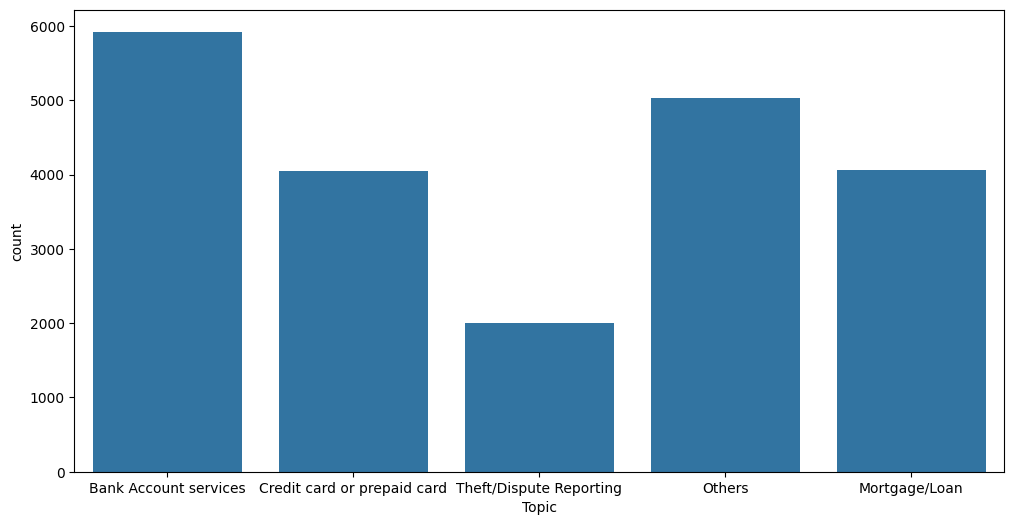

In [ ]:
# Plot graph to check class imbalance
plt.figure(figsize=(12,6))
sns.countplot(x='Topic',data=df_clean)

**Preprocessing for model**

In [ ]:
# Keep only necessary columns
training_data = df_clean[['complaint_text', 'Topic']]

training_data.head()

,complaint_text,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Bank Account services
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Bank Account services
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,Theft/Dispute Reporting
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,Bank Account services


**Reverse topic names mapping for supervised learning**

In [ ]:
## Reverse topic names mapping for supervised learning

reverse_topic_mapping = {
    'Bank Account services' :0,
    'Credit card or prepaid card':1,
    'Others':2,
    'Theft/Dispute Reporting':3,
    'Mortgage/Loan':4
}
#Replace Topics with Topic Names
training_data['Topic'] = training_data['Topic'].map(reverse_topic_mapping)
training_data.head()

,complaint_text,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,0
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,3
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,0


In [ ]:
# Display the first 30 complaint texts that are labeled with topic ID 2 (e.g., "Others")
training_data[['complaint_text','Topic']][training_data.Topic==2].head(30)

complaint_text  \
20   during the summer months i experience a decline income due to my employment therefore i request a one month payment extension with my auto loan company chase for the past almost fours years my request for payment extension is granted i have never been delinquent with my auto loan payment however on my request for a one month payment extension was denied this year i explained my situation to representative and the supervisor with no avail after a lengthy discussion and waiting i was informed the reason for the decline as it is not  contractual  this reason for denial baffled me and therefore i emailed the office of xxxx xxxx executive director communications jpmorgan chase  co a representative contacted me and stated chase will followup about week later a representative of xxxx xxxx xxxx xxxx office called the representative shared her role was help resolve the matter the representative via conference call contacted the department handing my request after reviewing my information my request was still denied based on  policy changes  i requested an explanation and representative stated a letter will be mailed with explanation i have received xxxx letters the reason for denial was not  policy changes  i would like cfpb help in exploring the denial of my payment extension request especially since i have been clear reason for denial                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [ ]:
# Split dataset
X = training_data['complaint_text']
y = training_data['Topic']

# Vectorization
count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

# TF-IDF Transformation
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)

# Train-test split using indices
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=40, stratify=y
)

# Use correct text values from X_train and X_test
X_train_text = X_train.tolist()  # Convert Series to list
X_test_text = X_test.tolist()


**Tokenization & LSTM Model Training**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Tokenization
tokenizer = Tokenizer(oov_token="<OOV>")  # Handle unseen words
tokenizer.fit_on_texts(X_train_text)

vocab_size = len(tokenizer.word_index) + 1
max_length = 100  # Truncate/Padding size

# Convert text to sequences
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=max_length, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test_text), maxlen=max_length, padding='post')

# Label encoding
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2025-05-02 00:39:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-02 00:39:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-02 00:39:49--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embedding_index = {}
with open('/content/glove.6B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# ---------------------- Build Improved RNN Model ---------------------- #
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Model

input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_length,
    trainable=False  # Freeze GloVe
)(input_layer)

x = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences=True)(x)      # New layer
x = Dropout(0.2)(x)
x = LSTM(32)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Use a smaller learning rate
optimizer = Adam(learning_rate=1e-3)  # Default is 1e-3
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


# -------------------------- Callbacks -------------------------------- #
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=0),
    ModelCheckpoint("best_rnn_model.keras", save_best_only=True, verbose=0)
]


In [ ]:
# ------------------------ Class Weights (Optional) ------------------- #
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_enc),
    y=y_train_enc
)
class_weights_dict = dict(enumerate(class_weights))

# ---------------------- Train the Model ----------------------------- #
history = model.fit(
    X_train_seq, y_train_enc,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_seq, y_test_enc),
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)
ModelCheckpoint("best_rnn_model.keras", save_best_only=True, verbose=0)


Epoch 1/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.2707 - loss: 1.5311 - val_accuracy: 0.5044 - val_loss: 1.2652 - learning_rate: 0.0010
Epoch 2/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.5654 - loss: 1.0289 - val_accuracy: 0.7044 - val_loss: 0.7991 - learning_rate: 0.0010
Epoch 3/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7328 - loss: 0.7254 - val_accuracy: 0.7684 - val_loss: 0.6741 - learning_rate: 0.0010
Epoch 4/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.7866 - loss: 0.5901 - val_accuracy: 0.7734 - val_loss: 0.6427 - learning_rate: 0.0010
Epoch 5/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.8049 - loss: 0.5306 - val_accuracy: 0.7862 - val_loss: 0.6117 - learning_rate: 0.0010
Epoch 6/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.8222 - loss: 0.4847 - val_accuracy: 0.7827 - val_loss: 0.6160 - learning_rate: 0.0010
Epoch 7/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.8

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Load the best saved model
best_model = load_model("best_rnn_model.keras")  # or .keras if you saved it with the new format

# Predict and evaluate
y_pred_probs_best = best_model.predict(X_test_seq)
y_pred_rnn_best = np.argmax(y_pred_probs_best, axis=1)

# Calculate and print the accuracy of the model
acc_best = accuracy_score(y_test_enc, y_pred_rnn_best)
print(f"\n Best Model Accuracy: {acc_best:.4f}")
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred_rnn_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_enc, y_pred_rnn_best))


132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

 Best Model Accuracy: 0.7862

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81      1185
           1       0.76      0.74      0.75       809
           2       0.89      0.76      0.82      1007
           3       0.67      0.90      0.77       401
           4       0.74      0.79      0.76       813

    accuracy                           0.79      4215
   macro avg       0.78      0.80      0.78      4215
weighted avg       0.79      0.79      0.79      4215


Confusion Matrix:
 [[953  68  41  36  87]
 [ 47 599  21  60  82]
 [ 87  41 761  65  53]
 [  7  19   9 359   7]
 [ 69  63  25  14 642]]


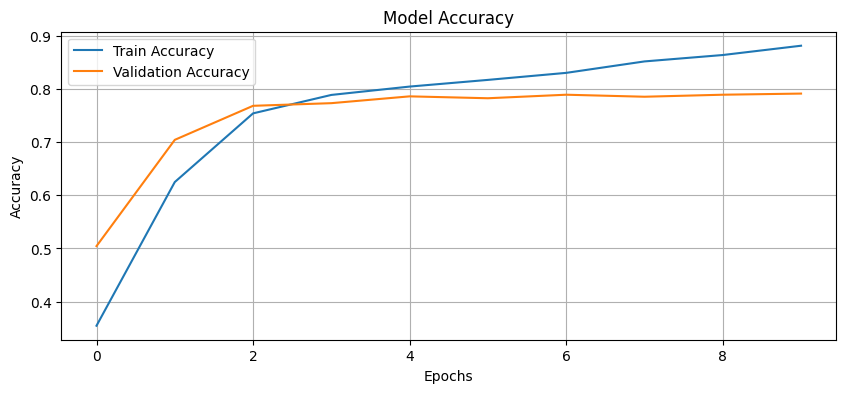

In [ ]:
# Plot training vs validation accuracy
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

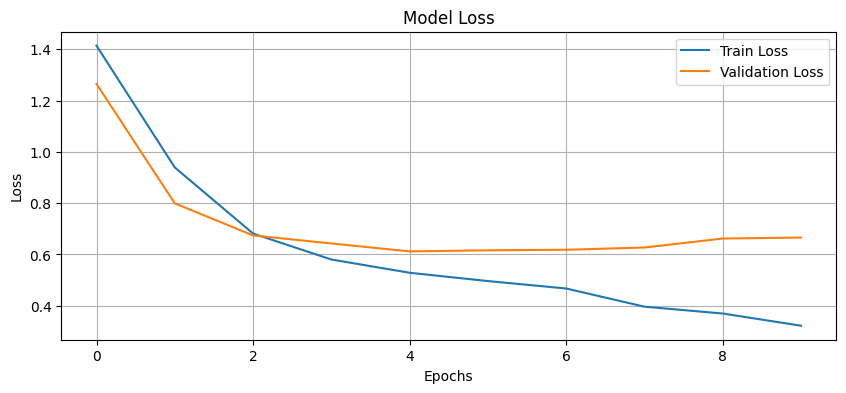

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

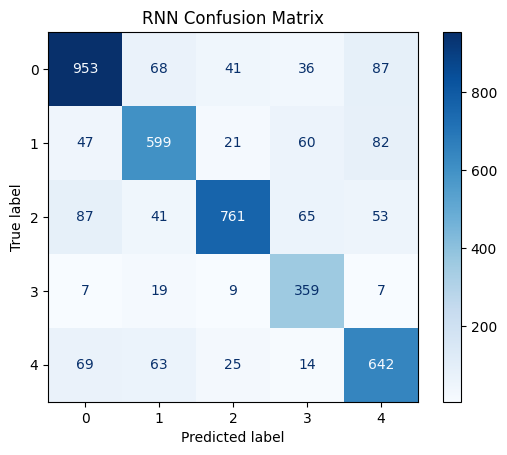

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# RNN Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_pred_rnn_best, display_labels=label_encoder.classes_, cmap='Blues')
plt.title("RNN Confusion Matrix")
plt.show()

In [ ]:
from tensorflow.keras.models import Model

# Load trained RNN model if not already loaded
# model = load_model("best_rnn_model.h5")

# Extract output from the last LSTM layer (LSTM with 32 units)
# Use model.summary() to verify the index (or use the layer name directly)
model.summary()  # Optional: to inspect and confirm layer positions

# Create a new model that outputs the last LSTM feature layer
# feature_extractor = Model(inputs=model.input, outputs=model.get_layer(index=-4).output)
# Extract output from the last Dense layer (before softmax)
feature_extractor = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)
X_test_features = feature_extractor.predict(X_test_seq)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 300)       │     8,920,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 64)        │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,529,777 (40.17 MB)

 Trainable params: 536,325 (2.05 MB)

 Non-trainable params: 8,920,800 (34.03 MB)

 Optimizer params: 1,072,652 (4.09 MB)

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [ ]:
# Apply feature extractor to test data
X_test_features = feature_extractor.predict(X_test_seq)

# Output shape: (num_samples, 32) if your last LSTM layer has 32 units
print("Extracted Feature Shape:", X_test_features.shape)


132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Extracted Feature Shape: (4215, 64)


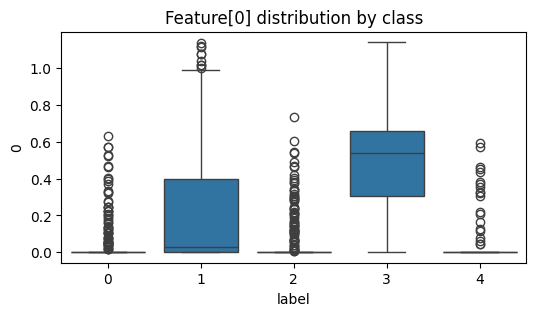

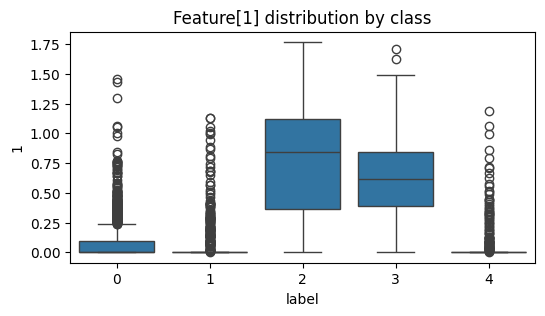

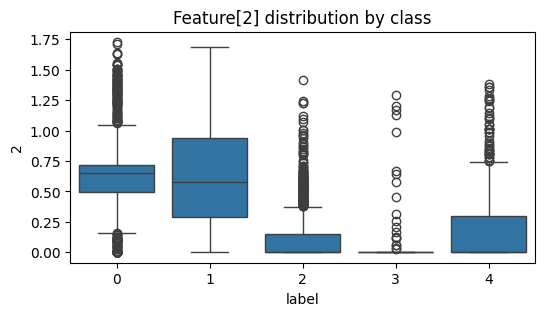

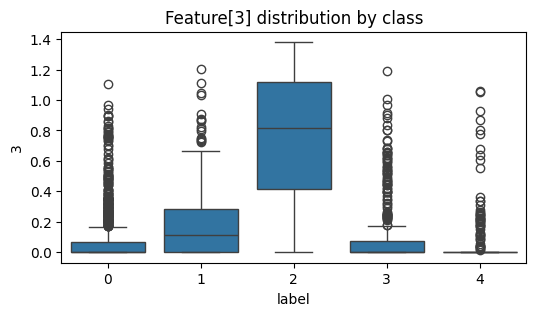

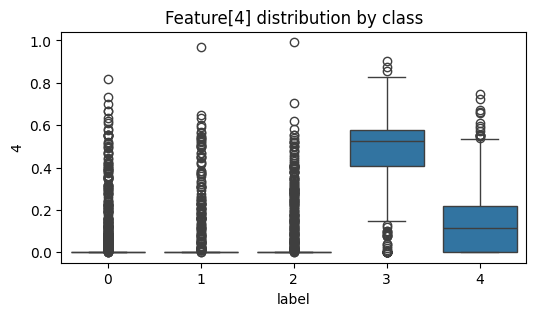

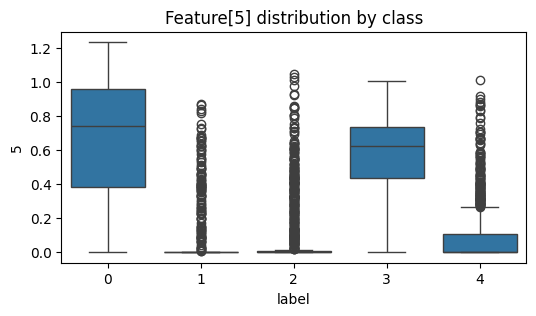

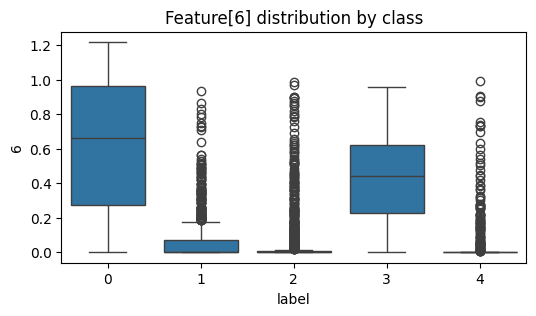

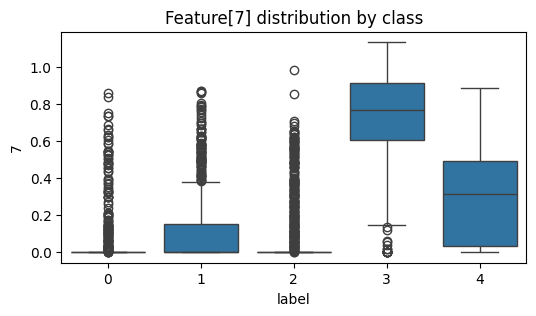

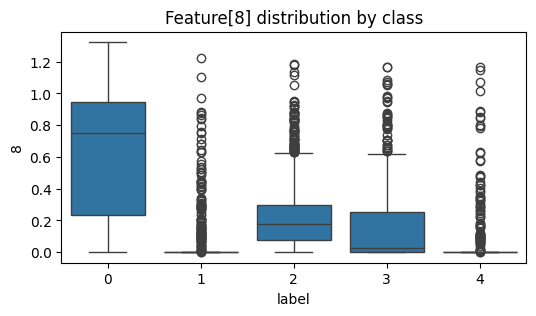

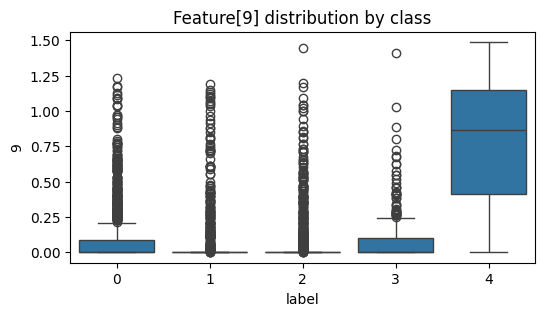

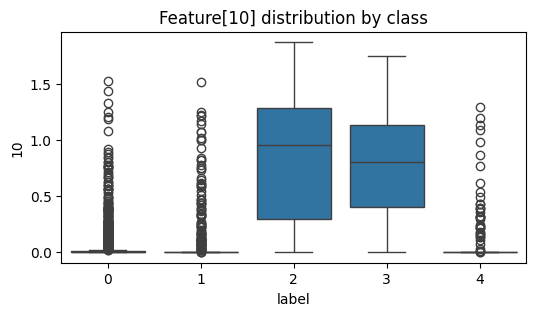

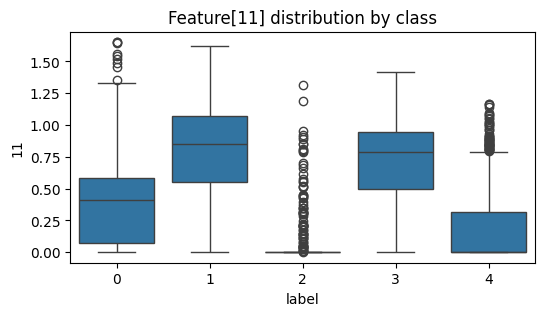

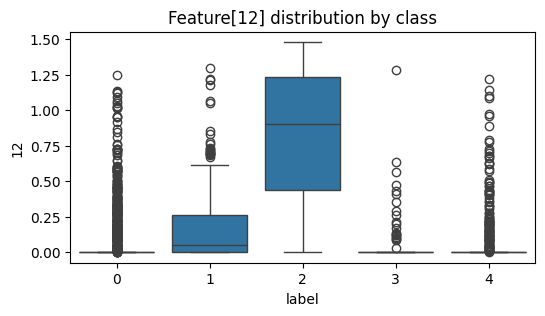

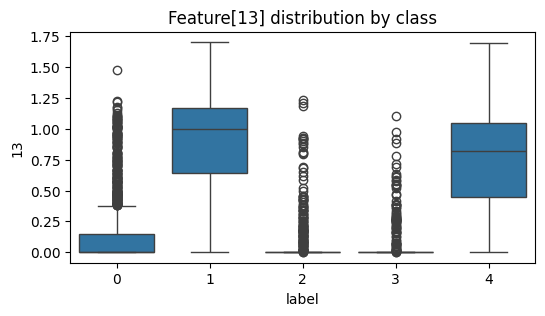

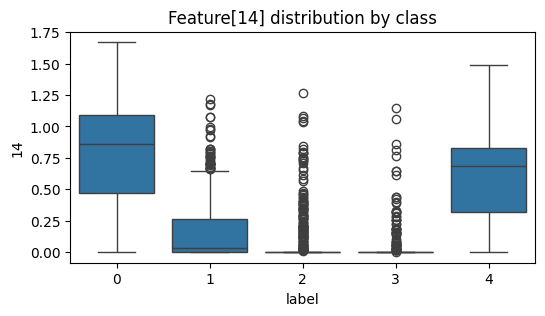

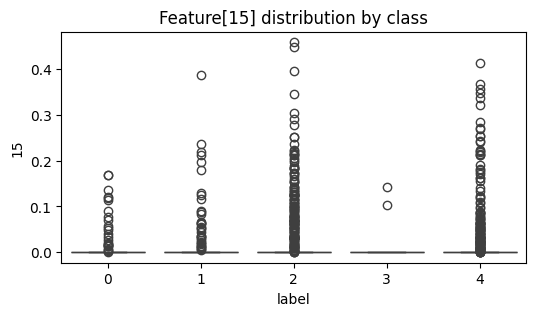

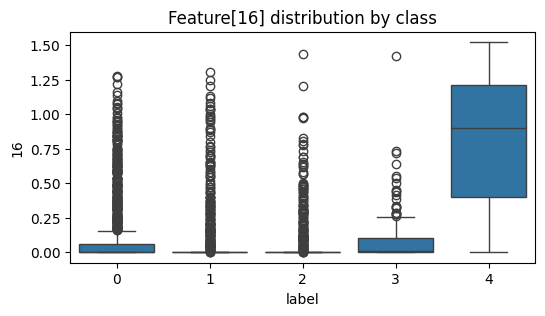

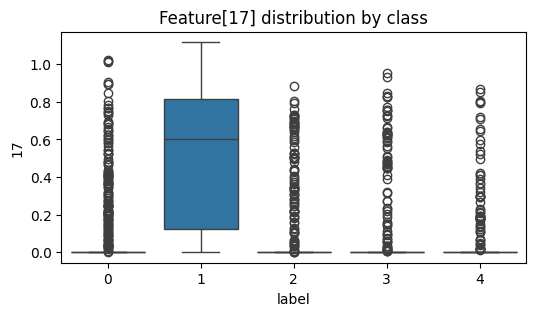

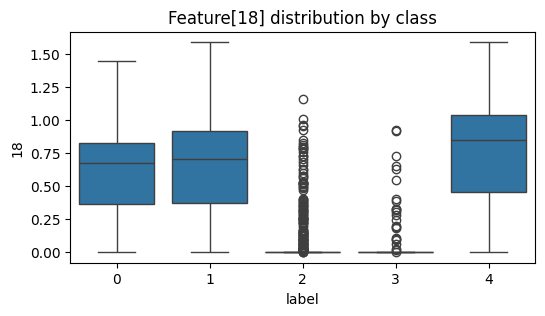

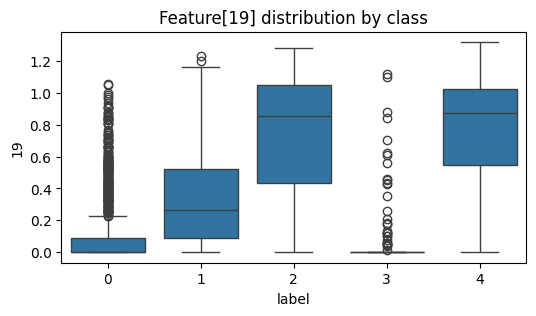

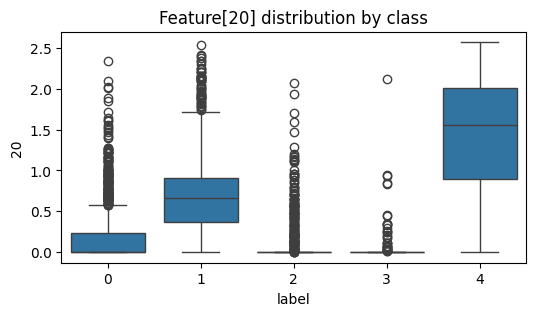

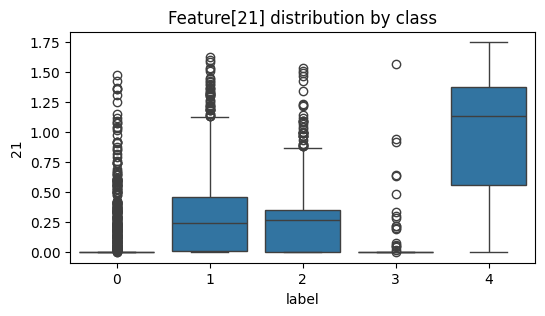

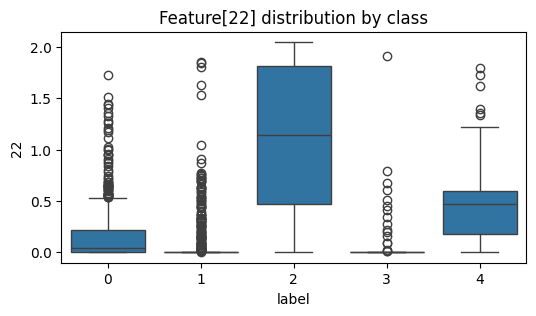

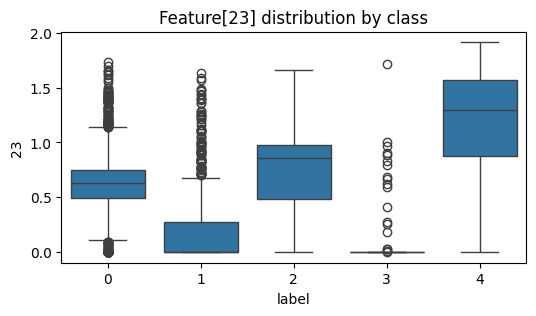

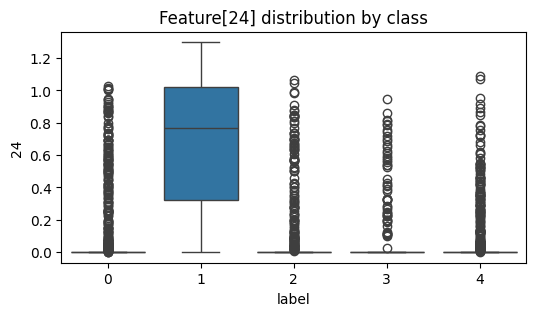

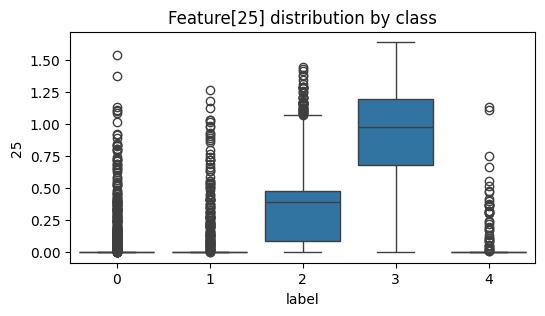

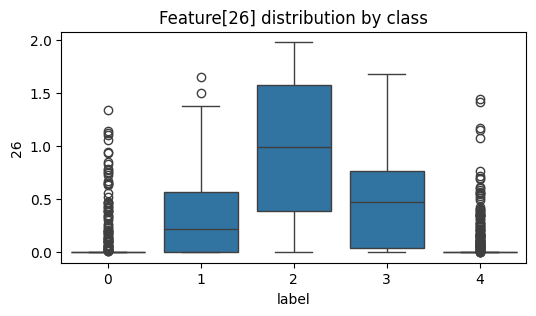

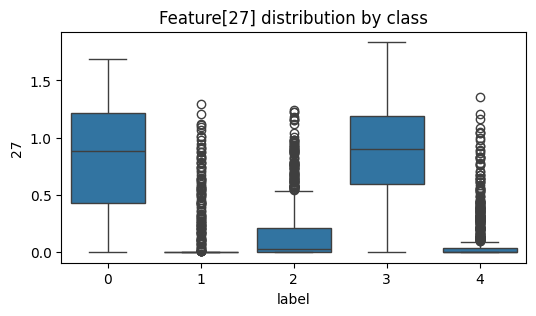

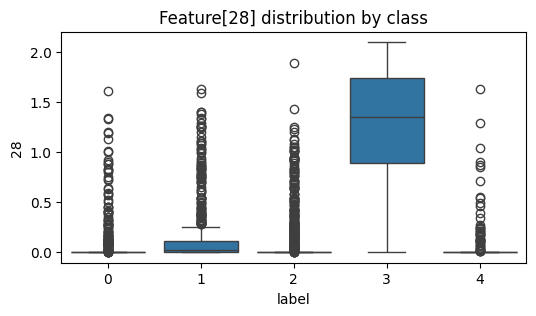

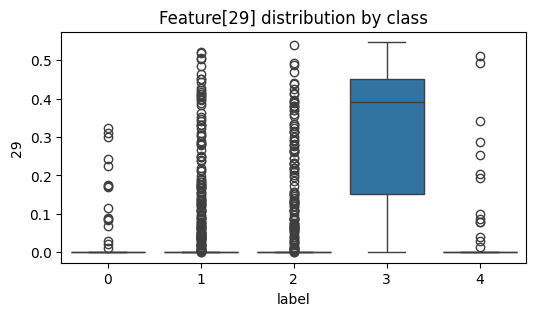

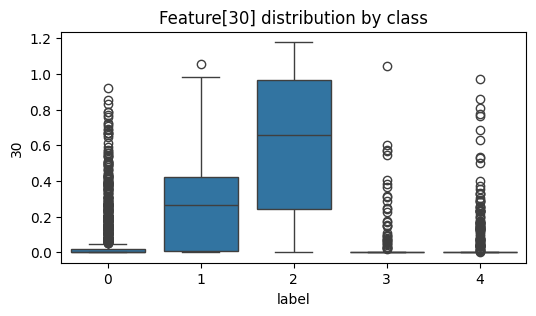

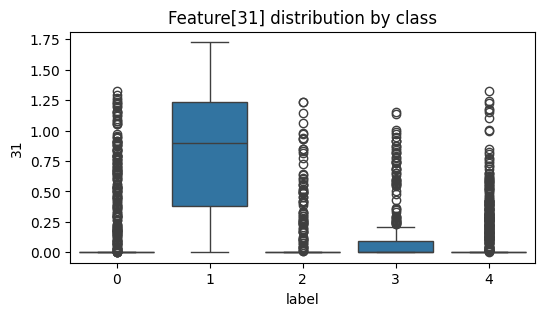

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine features with actual labels
df_feat = pd.DataFrame(X_test_features)
df_feat['label'] = y_test_enc

# Example: Visualize feature[10] across classes
for i in range(32):  # Loop through all 32 features
    plt.figure(figsize=(6,3))
    sns.boxplot(x='label', y=i, data=df_feat)
    plt.title(f"Feature[{i}] distribution by class")
    plt.show()


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train a Decision Tree on the extracted RNN features
# dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)  # Use shallow tree for explainability
# dt_model.fit(X_test_features, y_test_enc)

# # Predict using the trained Decision Tree
# rule_preds = dt_model.predict(X_test_features)

dt_model = DecisionTreeClassifier(max_depth=6, random_state=42)
dt_model.fit(X_test_features, y_test_enc)
rule_preds = dt_model.predict(X_test_features)

# Evaluate
acc_rules = accuracy_score(y_test_enc, rule_preds)
print(f"\n Rule-Based (Decision Tree) Accuracy: {acc_rules:.4f}")
print("\nClassification Report:\n", classification_report(y_test_enc, rule_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_enc, rule_preds))



 Rule-Based (Decision Tree) Accuracy: 0.8233

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      1185
           1       0.83      0.76      0.79       809
           2       0.86      0.85      0.85      1007
           3       0.82      0.84      0.83       401
           4       0.77      0.81      0.79       813

    accuracy                           0.82      4215
   macro avg       0.82      0.82      0.82      4215
weighted avg       0.82      0.82      0.82      4215


Confusion Matrix:
 [[1009   35   49   11   81]
 [  47  611   46   39   66]
 [  76   18  852   17   44]
 [  16   13   26  338    8]
 [  69   56   21    7  660]]


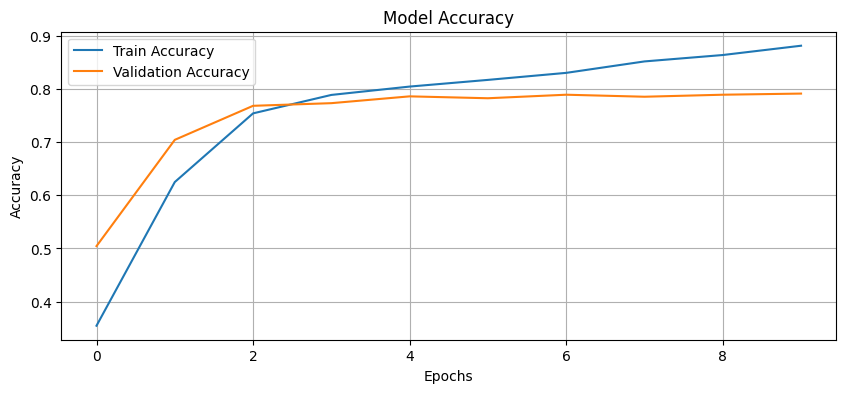

In [ ]:
# Plot training vs validation accuracy
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

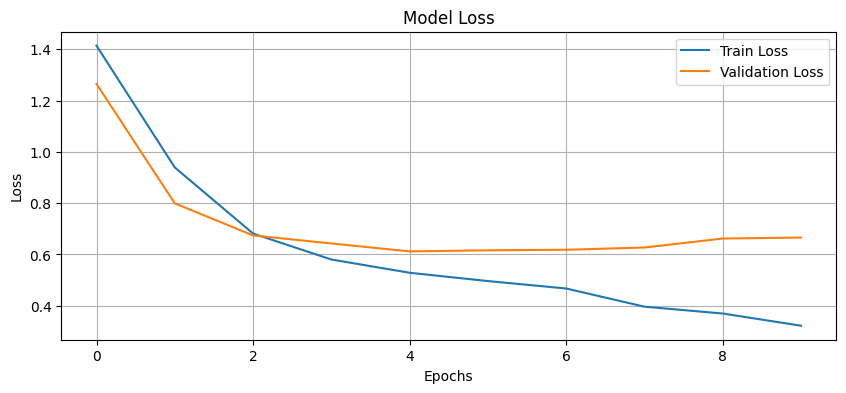

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

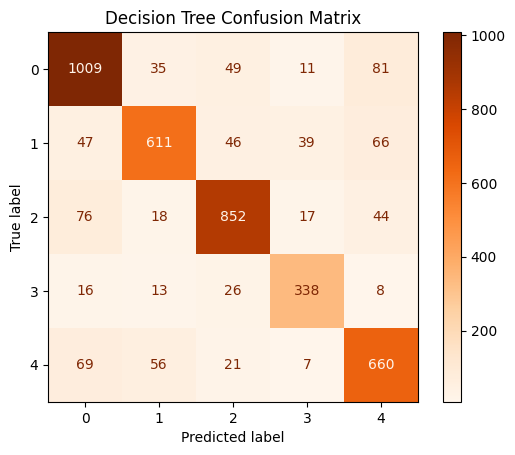

In [ ]:
# Rule-Based Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_enc, rule_preds, display_labels=label_encoder.classes_, cmap='Oranges')
plt.title("Decision Tree Confusion Matrix")
plt.show()

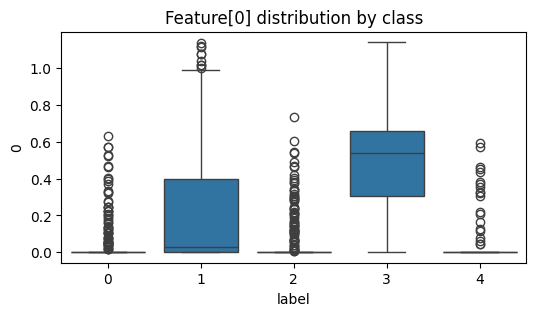

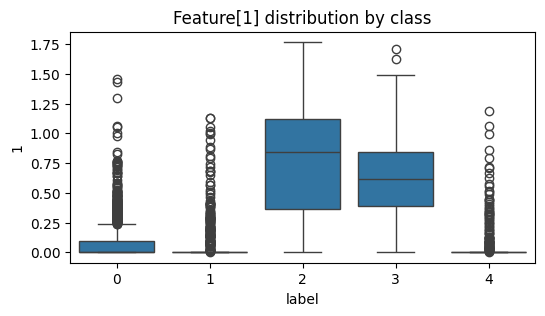

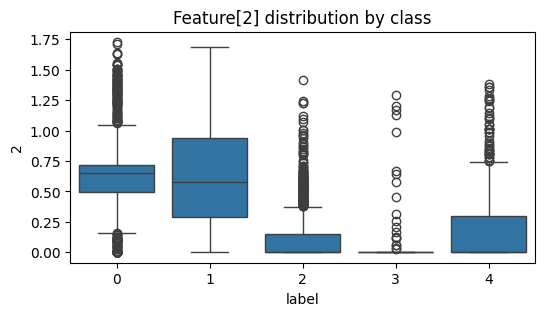

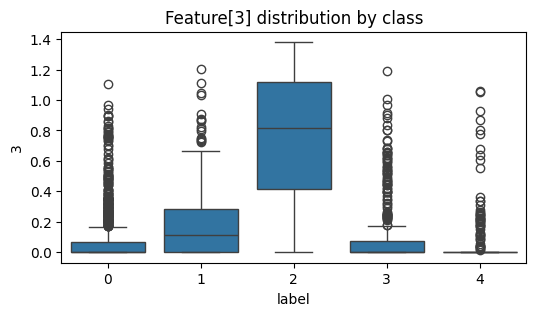

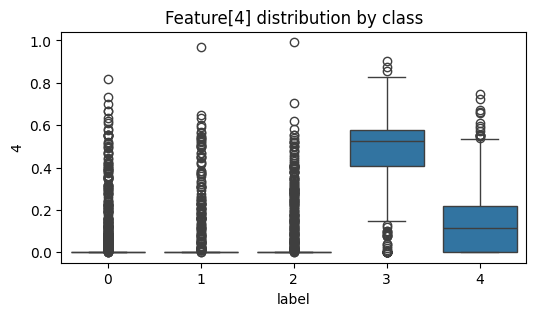

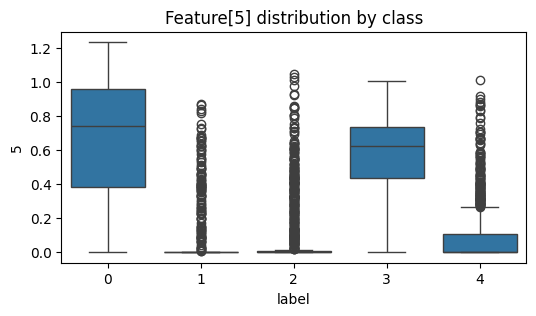

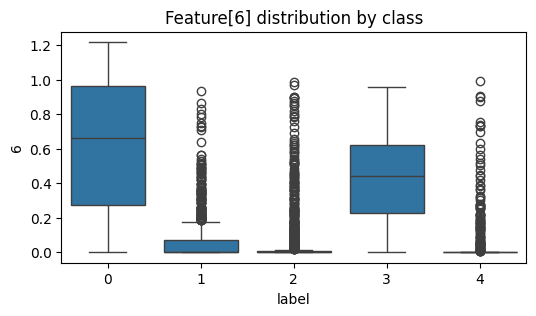

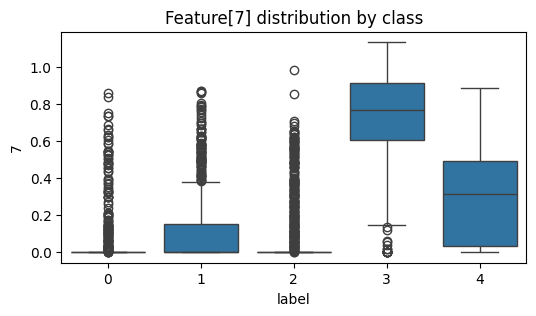

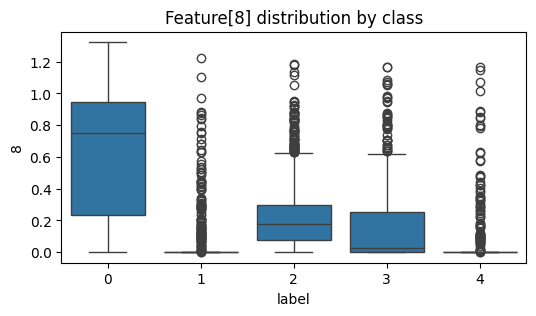

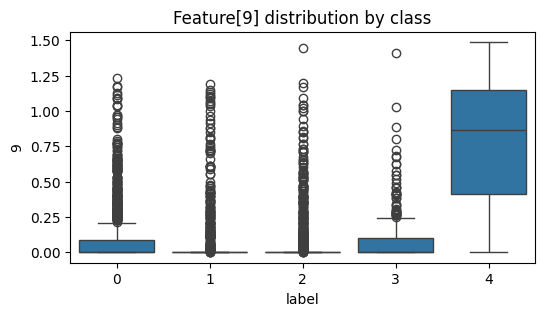

In [ ]:
# Create a DataFrame from the extracted LSTM features of the test set
df_feat = pd.DataFrame(X_test_features)
df_feat['label'] = y_test_enc


# Loop through the first 10 features to visualize their distribution across different classes
for i in range(10):
    plt.figure(figsize=(6,3))
    sns.boxplot(x='label', y=i, data=df_feat)
    plt.title(f"Feature[{i}] distribution by class")
    plt.show()


In [ ]:
# Fix: match the actual number of features from your LSTM output
num_features = X_test_features.shape[1]

# Create the correct number of feature names dynamically
feature_names = [f'feature_{i}' for i in range(num_features)]

# Export readable rules
from sklearn.tree import export_text
rules_text = export_text(dt_model, feature_names=feature_names)
print(rules_text)

|--- feature_35 <= 0.36
|   |--- feature_45 <= 0.00
|   |   |--- feature_59 <= 0.31
|   |   |   |--- feature_28 <= 1.06
|   |   |   |   |--- feature_13 <= 0.01
|   |   |   |   |   |--- feature_26 <= 0.01
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_26 >  0.01
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- feature_13 >  0.01
|   |   |   |   |   |--- feature_32 <= 0.69
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- feature_32 >  0.69
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- feature_28 >  1.06
|   |   |   |   |--- feature_58 <= 0.01
|   |   |   |   |   |--- feature_56 <= 0.48
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- feature_56 >  0.48
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |--- feature_58 >  0.01
|   |   |   |   |   |--- feature_60 <= 0.09
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_60 >  0.09
|   |   |   |   |   |   |--- class: 0
|   |   |--- feature_59 >  0

In [ ]:
# Use the trained Decision Tree model to predict class labels from LSTM-extracted features
rule_preds = dt_model.predict(X_test_features)

# Calculate and print the accuracy of the rule-based (Decision Tree) model
acc_rules = accuracy_score(y_test_enc, rule_preds)
print("Rule-Based Accuracy:", acc_rules)


Rule-Based Accuracy: 0.8232502965599051


In [ ]:
# RNN predictions:
y_pred_rnn_best = np.argmax(best_model.predict(X_test_seq), axis=1)
acc_rnn = accuracy_score(y_test_enc, y_pred_rnn_best)

# Rule-based:
acc_rules = accuracy_score(y_test_enc, rule_preds)

# Hybrid (Rule fallback, else RNN):
hybrid_preds = []
for i, tree_pred in enumerate(rule_preds):
    if tree_pred != 2:  # not fallback
        hybrid_preds.append(tree_pred)
    else:
        hybrid_preds.append(y_pred_rnn_best[i])
acc_hybrid = accuracy_score(y_test_enc, hybrid_preds)


132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [ ]:
def predict_ticket_hybrid(text):
    # Step 1: Clean and preprocess
    text_clean = clean_text(text)
    text_seq = tokenizer.texts_to_sequences([text_clean])
    text_pad = pad_sequences(text_seq, maxlen=max_length, padding='post')

    # Step 2: Extract features using trained LSTM feature extractor
    lstm_features = feature_extractor.predict(text_pad)

    # Step 3: Rule-based prediction using Decision Tree
    tree_pred = dt_model.predict(lstm_features)[0]

    # Step 4: Fallback to RNN if rule is uncertain (e.g., class 2 = "Others")
    if tree_pred == 2:
        rnn_pred = np.argmax(best_model.predict(text_pad), axis=1)[0]
        final_pred = rnn_pred
    else:
        final_pred = tree_pred

    # Step 5: Decode class label
    index_to_topic = {
        0: 'Bank Account services',
        1: 'Credit card or prepaid card',
        2: 'Others',
        3: 'Theft/Dispute Reporting',
        4: 'Mortgage/Loan'
    }

    return index_to_topic[final_pred]


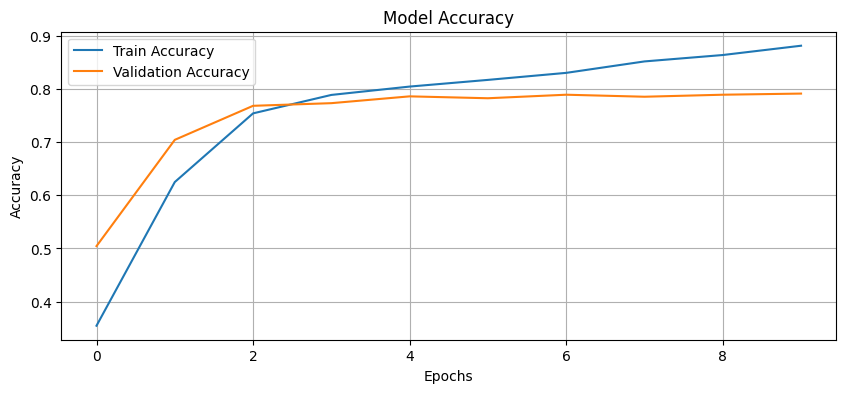

In [ ]:
# Plot training vs validation accuracy
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

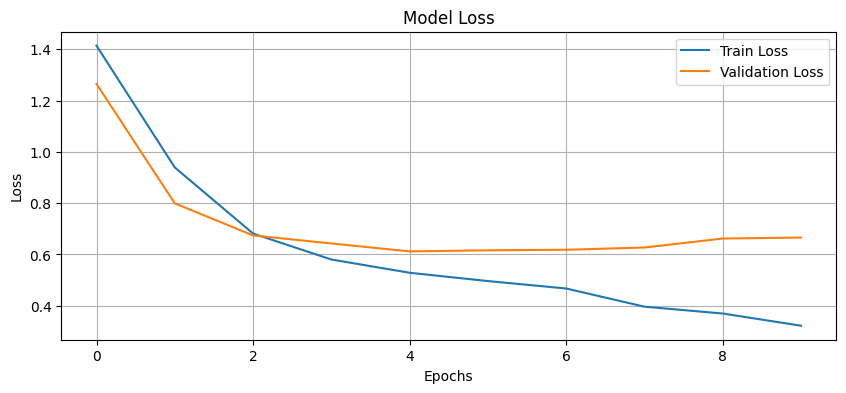

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

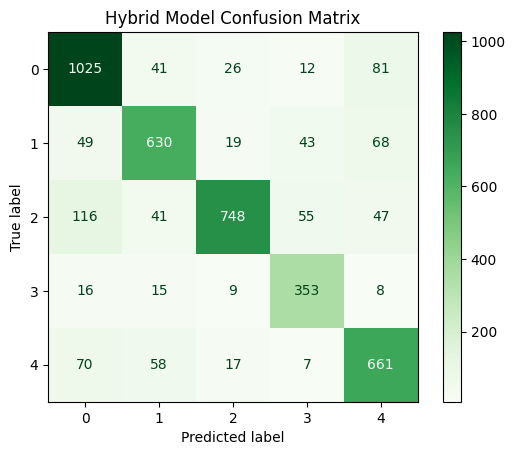

In [ ]:
# Hybrid Model Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_enc, hybrid_preds, display_labels=label_encoder.classes_, cmap='Greens')
plt.title("Hybrid Model Confusion Matrix")
plt.show()

In [ ]:
# Define a sample customer complaint to test the hybrid prediction system
text = "My mortgage payment is showing as overdue even after I paid last week."

# Use the hybrid prediction function:
prediction = predict_ticket_hybrid(text)

# Print the predicted category (e.g., 'Mortgage/Loan', 'Credit card or prepaid card', etc.)
print("Predicted Category (Hybrid):", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Category (Hybrid): Others


In [ ]:
# Display accuracy comparison table in Colab
import pandas as pd

accuracy_df = pd.DataFrame({
    "Model": ["RNN (Deep Learning)", "Decision Tree (Rule-Based)", "Hybrid (Rule + RNN)"],
    "Accuracy": [acc_rnn, acc_rules, acc_hybrid]
})

accuracy_df["Accuracy"] = accuracy_df["Accuracy"].round(4)

# Show the table
print("\nModel Accuracy Comparison:\n")
print(accuracy_df)



Model Accuracy Comparison:

                        Model  Accuracy
0  RNN (Deep Learning)         0.7862  
1  Decision Tree (Rule-Based)  0.8233  
2  Hybrid (Rule + RNN)         0.8107  


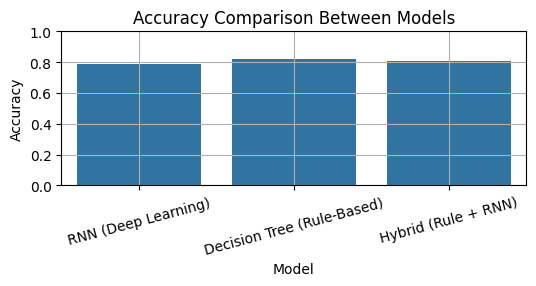

In [ ]:
#Accuracy Comaprison Models
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,2))
sns.barplot(x="Model", y="Accuracy", data=accuracy_df)
plt.title("Accuracy Comparison Between Models")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.grid(True)
plt.show()


**Define All 3 Prediction Functions**

In [ ]:
# Rule-based prediction only
def predict_rule(text):
    text_clean = clean_text(text)
    text_seq = tokenizer.texts_to_sequences([text_clean])
    text_pad = pad_sequences(text_seq, maxlen=max_length, padding='post')
    features = feature_extractor.predict(text_pad)
    pred = dt_model.predict(features)[0]
    return pred

# RNN prediction only
def predict_rnn(text):
    text_clean = clean_text(text)
    text_seq = tokenizer.texts_to_sequences([text_clean])
    text_pad = pad_sequences(text_seq, maxlen=max_length, padding='post')
    pred = np.argmax(best_model.predict(text_pad), axis=1)[0]
    return pred

# Hybrid: fallback to RNN if rule is uncertain
def predict_hybrid(text):
    rule_pred = predict_rule(text)
    if rule_pred == 2:  # "Others" fallback
        return predict_rnn(text)
    else:
        return rule_pred


**Mapping Labels to Names**

In [ ]:
index_to_topic = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}


**Build the Widget Interface**



In [ ]:
import ipywidgets as widgets
from IPython.display import display, Markdown

# Input field
input_box = widgets.Textarea(
    value='',
    placeholder='Enter a complaint...',
    description='Ticket:',
    layout=widgets.Layout(width='100%', height='100px')
)

# Output area
output_box = widgets.Output()

# Button
predict_button = widgets.Button(description="Classify with All Models")

# Button click logic
def on_button_click_all(b):
    with output_box:
        output_box.clear_output()
        text = input_box.value.strip()
        if not text:
            print(" Please enter a complaint.")
            return

        rule = index_to_topic[predict_rule(text)]
        rnn = index_to_topic[predict_rnn(text)]
        hybrid = index_to_topic[predict_hybrid(text)]

        display(Markdown(f"### Prediction Results\n"
                         f"- **RNN Prediction**: `{rnn}`\n"
                         f"- **Rule-Based Prediction**: `{rule}`\n"
                         f"- **Hybrid Prediction**: `{hybrid}`"))

# Bind button
predict_button.on_click(on_button_click_all)

# Display the interface
display(input_box, predict_button, output_box)


Textarea(value='', description='Ticket:', layout=Layout(height='100px', width='100%'), placeholder='Enter a co…

Button(description='Classify with All Models', style=ButtonStyle())

Output()